# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

> **Note**: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code and results presented here.

## Overview

This notebook explores [Dandiset 000617 (version 0.250312.0130)](https://dandiarchive.org/dandiset/000617/0.250312.0130), which contains data from the Allen Institute's Openscope Sequence Learning Project. The project investigates how the mouse brain responds to and learns sequences of visual stimuli.

In this experiment, head-fixed mice passively viewed sequences of three different natural movie clips (labeled 'A', 'B', 'C'), each with a duration of 2 seconds, as well as a 2-second gray screen. The experiment consists of different sessions:
- An initial session with randomly presented movie clips and gray screens
- Three training sessions with the movie clips presented in a repeating sequence (ABCABC...)
- A final session with random presentations to assess changes due to learning

The researchers used two-photon microscopy to record neural activity from different layers (L2/3 and L4) of multiple visual cortical areas: V1 (VISp), LM (VISl), AM (VISam), and PM (VISpm). The experiments were performed using the Cux2-CreERTS2:Camk2a-tTa; Ai93(TITL-GCaMP6f) mouse line, which expresses GCaMP6f in excitatory neurons in layers 2/3 and 4.

In this notebook, we'll explore the data from one of these recordings, focusing on:
- Understanding the structure and content of the NWB files
- Visualizing neural activity in response to different stimuli
- Examining the relationship between neural activity and mouse behavior (running)
- Identifying neurons that show specific response patterns

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Set seaborn style for better visualization
sns.set_theme()

## Loading the Dandiset

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000617", "0.250312.0130")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Version: {metadata['version']}")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130
Version: 0.250312.0130


Let's list some assets in the Dandiset to understand what files are available:

In [3]:
# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")


First 5 assets:
- sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb (ID: 3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8)
- sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb (ID: 4cfa15bb-eac7-4273-9141-6d0cc2034506)
- sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb (ID: d0b9a557-2c98-4fbc-af96-2318e6e5f2eb)
- sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb (ID: 6b8f9ba6-2481-4c7b-b78c-38c2b878d246)
- sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb (ID: c407d5e4-9431-4f94-b5d0-2b28069fa244)


## Loading an NWB File

For this exploration, we'll focus on one of the NWB files from the dataset. We selected `sub-677038_ses-1280089433-acq-1280384858_ophys.nwb`, which contains processed data from a two-photon calcium imaging session. This file is a reasonable size (~700MB) and contains both neural activity data and behavioral measurements, making it suitable for our exploration. The larger 'raw-movies' files (~20GB) contain the raw imaging data, which we won't need for this analysis.

In [4]:
# Define the URL for an NWB file from the Dandiset
asset_id = "27dd7936-b3e7-45af-aca0-dc98b5954d19"  # ID for sub-677038_ses-1280089433-acq-1280384858_ophys.nwb
url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
print(f"Loading NWB file from {url}")

# Load the file using remfile and h5py
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Loading NWB file from https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/


## NWB File Structure and Content

Let's examine the basic metadata of the file:

In [5]:
print(f"Session description: {nwb.session_description}")
print(f"Session identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"\nSubject information:")
print(f"  ID: {nwb.subject.subject_id}")
print(f"  Species: {nwb.subject.species}")
print(f"  Age: {nwb.subject.age}")
print(f"  Sex: {nwb.subject.sex}")
print(f"  Genotype: {nwb.subject.genotype}")

Session description: Ophys Session
Session identifier: 1280384858
Session start time: 2023-06-30 16:04:51.055000+00:00
Experiment description: ophys session

Subject information:
  ID: 677038
  Species: Mus musculus
  Age: P92.0D
  Sex: F
  Genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt


### Data Organization in the NWB File

NWB (Neurodata Without Borders) files organize data in a hierarchical structure. Let's examine the main components of this file:

In [6]:
# Print main groups in the file
print("Main groups in the NWB file:")
for field in nwb.fields.keys():
    if field != 'stimulus_template' and hasattr(nwb, field) and hasattr(getattr(nwb, field), 'items'):
        print(f"  - {field}")

print("\nAcquisition data (raw measurements):")
for name, data in nwb.acquisition.items():
    print(f"  - {name} ({type(data).__name__})")

print("\nStimulus templates (visual stimuli presented):")
for name, data in nwb.stimulus_template.items():
    print(f"  - {name} ({type(data).__name__})")

print("\nProcessing modules (analyzed data):")
for module_name, module in nwb.processing.items():
    print(f"  - {module_name} ({module.description}):")
    for name, interface in module.data_interfaces.items():
        print(f"    * {name} ({type(interface).__name__})")

Main groups in the NWB file:
  - acquisition
  - processing
  - devices
  - imaging_planes
  - intervals
  - lab_meta_data

Acquisition data (raw measurements):
  - v_in (TimeSeries)
  - v_sig (TimeSeries)

Stimulus templates (visual stimuli presented):
  - gray (ImageSeries)
  - movie_clip_A (ImageSeries)
  - movie_clip_B (ImageSeries)
  - movie_clip_C (ImageSeries)

Processing modules (analyzed data):
  - ophys (Ophys processing module):
    * corrected_fluorescence (Fluorescence)
    * dff (DfOverF)
    * event_detection (OphysEventDetection)
    * image_segmentation (ImageSegmentation)
    * images (Images)
    * neuropil_trace (Fluorescence)
    * ophys_motion_correction_x (TimeSeries)
    * ophys_motion_correction_y (TimeSeries)
  - running (Running speed processing module):
    * dx (TimeSeries)
    * speed (TimeSeries)
    * speed_unfiltered (TimeSeries)
  - stimulus (Stimulus Times processing):
    * timestamps (TimeSeries)
  - stimulus_ophys (Stimulus Times processing):
    *

Let's take a closer look at the regions of interest (ROIs) identified in this recording:

In [7]:
# Get information about ROIs
ophys = nwb.processing['ophys']
image_seg = ophys.data_interfaces['image_segmentation']
plane_seg = image_seg.plane_segmentations['cell_specimen_table']
imaging_plane = plane_seg.imaging_plane

print(f"Imaging plane description: {imaging_plane.description}")
print(f"Imaging plane location: {imaging_plane.location}")
print(f"Imaging rate: {imaging_plane.imaging_rate} Hz")
print(f"Indicator: {imaging_plane.indicator}")

# Number of ROIs
num_rois = len(plane_seg.id.data[:])
print(f"Number of ROIs: {num_rois}")

Imaging plane description: (512, 512) field of view in VISp at depth 175 um
Imaging plane location: VISp
Imaging rate: 10.0 Hz
Indicator: GCaMP6f
Number of ROIs: 121


Let's check what stimulus presentations are recorded in the data:

In [8]:
# Get information about stimulus presentations
print("\nStimulus presentation information:")
for stim_name in ['gray_presentations', 'movie_clip_A_presentations', 'movie_clip_B_presentations', 'movie_clip_C_presentations']:
    presentations = nwb.intervals[stim_name]
    num_presentations = len(presentations.id.data[:])
    print(f"{stim_name}: {num_presentations} presentations")
    if num_presentations > 0:
        first_start = presentations.start_time.data[0]
        first_stop = presentations.stop_time.data[0]
        first_duration = first_stop - first_start
        print(f"  First presentation: start={first_start:.2f}s, stop={first_stop:.2f}s, duration={first_duration:.2f}s")

# Note about stimulus frame presentations
print("\nNote: While the experiment description mentions 2-second movie clips, the data shows")
print("individual frame presentations (~0.02s each). A complete movie clip would consist")
print("of multiple consecutive frames (about 120 frames at 60Hz = 2 seconds).")

# Let's check the frame numbers to confirm this
for stim_name in ['movie_clip_A_presentations']:
    presentations = nwb.intervals[stim_name]
    frames = presentations.frame.data[:]
    unique_frames = np.unique(frames)
    print(f"\n{stim_name} unique frames: {len(unique_frames)} (min: {min(unique_frames)}, max: {max(unique_frames)})")


Stimulus presentation information:
gray_presentations: 63000 presentations
  First presentation: start=34.92s, stop=34.93s, duration=0.02s


movie_clip_A_presentations: 63000 presentations
  First presentation: start=22.91s, stop=22.92s, duration=0.02s


movie_clip_B_presentations: 63000 presentations
  First presentation: start=24.91s, stop=24.93s, duration=0.02s
movie_clip_C_presentations: 63000 presentations
  First presentation: start=26.91s, stop=26.93s, duration=0.02s

Note: While the experiment description mentions 2-second movie clips, the data shows
individual frame presentations (~0.02s each). A complete movie clip would consist
of multiple consecutive frames (about 120 frames at 60Hz = 2 seconds).



movie_clip_A_presentations unique frames: 120 (min: 0.0, max: 119.0)


### Motion Correction Data

Let's look at the motion correction data to assess the quality of the recording:

X motion range: -5 to 18 pixels
Y motion range: -4 to 23 pixels


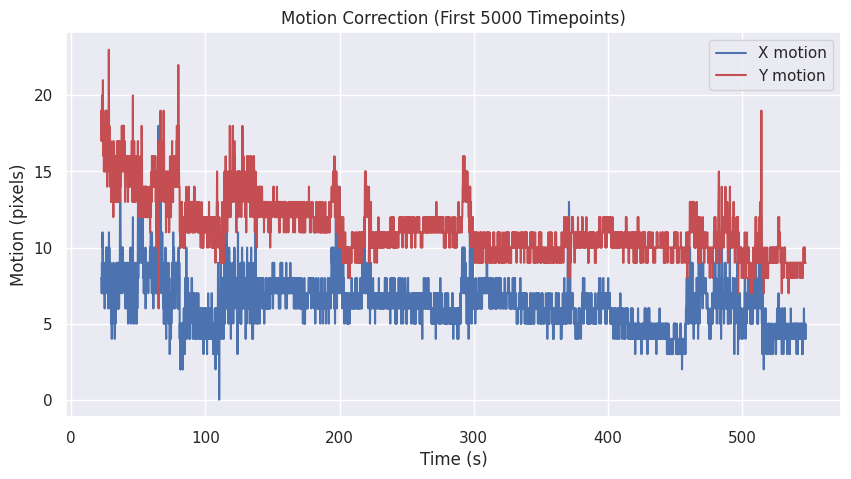

In [9]:
# Get motion correction data
motion_x = ophys.data_interfaces['ophys_motion_correction_x'].data[:]
motion_y = ophys.data_interfaces['ophys_motion_correction_y'].data[:]
motion_times = ophys.data_interfaces['ophys_motion_correction_x'].timestamps[:]

print(f"X motion range: {np.min(motion_x)} to {np.max(motion_x)} pixels")
print(f"Y motion range: {np.min(motion_y)} to {np.max(motion_y)} pixels")

# Plot motion correction (first 5000 timepoints)
plt.figure(figsize=(10, 5))
plt.plot(motion_times[:5000], motion_x[:5000], 'b-', label='X motion')
plt.plot(motion_times[:5000], motion_y[:5000], 'r-', label='Y motion')
plt.xlabel('Time (s)')
plt.ylabel('Motion (pixels)')
plt.title('Motion Correction (First 5000 Timepoints)')
plt.legend()
plt.grid(True)
plt.show()

The motion correction plot shows that there is moderate motion throughout the recording, with Y-motion (10-15 pixels) consistently higher than X-motion (5-8 pixels). There are several motion spikes, particularly in the beginning of the recording where peaks reach 20+ pixels in the Y direction. The motion generally decreases and stabilizes somewhat after the first few minutes.

## Calcium Imaging Data

Let's examine the neural activity data. We'll use the delta F/F (DF/F) traces, which represent the relative change in fluorescence over time:

In [10]:
# Get DF/F data
dff = ophys.data_interfaces['dff']
roi_response_series = dff.roi_response_series['traces']
dff_data = roi_response_series.data[:]  # shape: (timepoints, ROIs)
dff_times = roi_response_series.timestamps[:]

print(f"DF/F data shape: {dff_data.shape}")
print(f"Number of timepoints: {dff_data.shape[0]}")
print(f"Number of ROIs: {dff_data.shape[1]}")
print(f"Duration of recording: {dff_times[-1] - dff_times[0]:.2f} seconds")
print(f"Sampling rate: {dff_data.shape[0] / (dff_times[-1] - dff_times[0]):.2f} Hz")

DF/F data shape: (40019, 121)
Number of timepoints: 40019
Number of ROIs: 121
Duration of recording: 4204.45 seconds
Sampling rate: 9.52 Hz


Let's visualize the calcium traces for a few neurons:

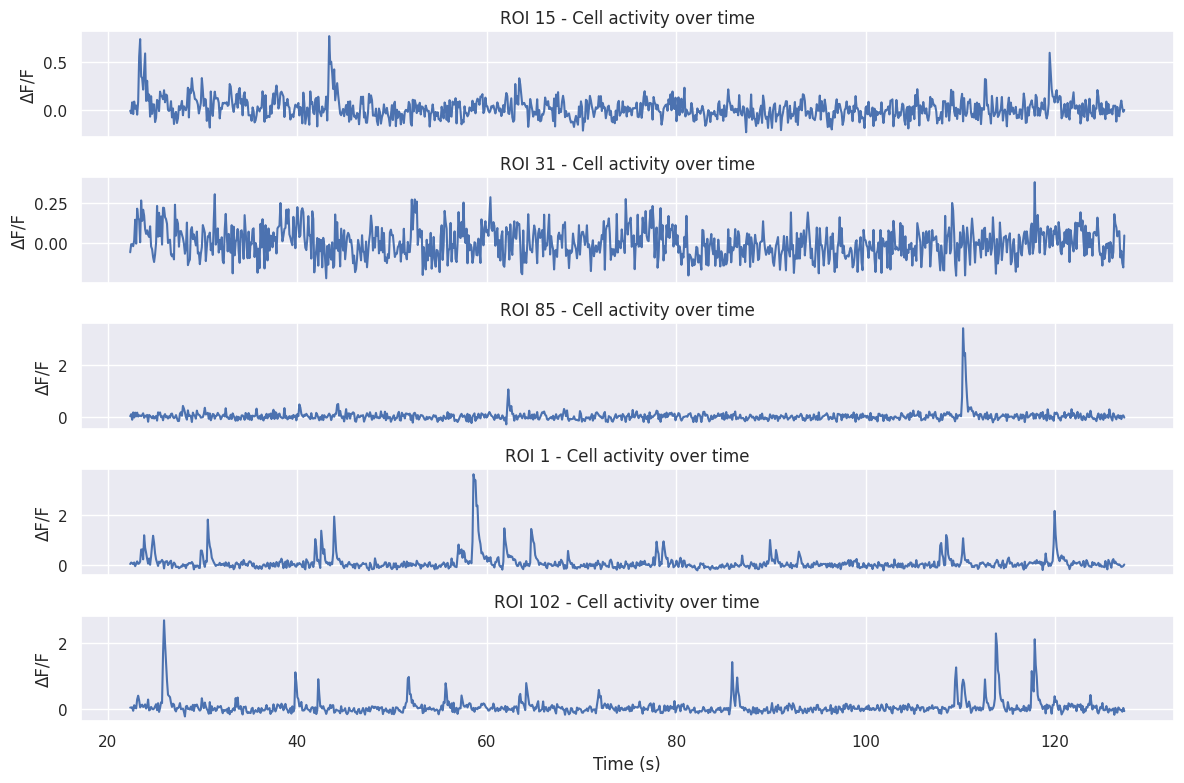

In [11]:

# Plot DF/F traces for 5 randomly selected ROIs (first 1000 timepoints)
plt.figure(figsize=(12, 8))
num_cells = 5
selected_indices = np.random.choice(dff_data.shape[1], num_cells, replace=False)

for i, idx in enumerate(selected_indices):
    plt.subplot(num_cells, 1, i+1)
    plt.plot(dff_times[:1000], dff_data[:1000, idx])
    plt.title(f'ROI {idx} - Cell activity over time')
    plt.ylabel('ΔF/F')
    if i == num_cells - 1:
        plt.xlabel('Time (s)')
    else:
        plt.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()

## Neural Responses to Visual Stimuli

Let's explore how neurons respond to the different visual stimuli (movie clips and gray screen). We'll align the neural activity to stimulus onset times and examine the responses:

In [12]:
# Helper function to get presentation times
def get_presentation_df(intervals_name):
    """Convert stimulus interval data to a DataFrame."""
    interval = nwb.intervals[intervals_name]
    data = {
        'start_time': interval.start_time.data[:],
        'stop_time': interval.stop_time.data[:],
        'stimulus_name': interval.stimulus_name.data[:],
        'stimulus_block': interval.stimulus_block.data[:] 
    }
    return pd.DataFrame(data)

# Get stimulus presentation times
stim_types = ['gray', 'movie_clip_A', 'movie_clip_B', 'movie_clip_C']
presentation_dfs = {}
for stim_type in stim_types:
    presentation_dfs[stim_type] = get_presentation_df(f"{stim_type}_presentations")

Now let's create a function to align neural activity to stimulus presentations:

In [13]:
def get_aligned_responses(presentation_df, dff_data, dff_times, roi_indices=None, 
                          window=(-0.5, 2.5), max_presentations=100):
    """
    Align neural data to stimulus presentations.
    
    Args:
        presentation_df: DataFrame with stimulus presentation times
        dff_data: Array of DF/F data (timepoints, ROIs)
        dff_times: Array of timestamps for DF/F data
        roi_indices: Indices of ROIs to include (if None, use all)
        window: Time window around stimulus onset (in seconds)
        max_presentations: Maximum number of presentations to analyze
        
    Returns:
        aligned_data: Array of shape (n_presentations, n_cells, n_timepoints)
        time_bins: Array of timepoints relative to stimulus onset
    """
    # Get stimulus onset times (limit by max_presentations and group by actual stimulus instances)
    # To handle the issue with individual frames, we'll group by stimulus block
    # and use the first frame of each block as the onset time for the full stimulus
    stimulus_blocks = presentation_df['stimulus_block'].unique()[:max_presentations//100]
    onset_times = []
    for block in stimulus_blocks:
        block_df = presentation_df[presentation_df['stimulus_block'] == block]
        if len(block_df) > 0:
            onset_times.append(block_df['start_time'].values[0])
    
    onset_times = np.array(onset_times)
    print(f"Analyzing {len(onset_times)} complete stimulus presentations")
    
    # Use specified ROIs or all
    if roi_indices is None:
        roi_indices = np.arange(dff_data.shape[1])
    
    # Create time bins relative to stimulus onset
    time_bins = np.linspace(window[0], window[1], 100)
    
    # Initialize aligned data array
    aligned_data = np.zeros((len(onset_times), len(roi_indices), len(time_bins)))
    
    # Use vectorized operations where possible to improve efficiency
    for i, onset_time in enumerate(onset_times):
        # Calculate all time offsets at once
        times = onset_time + time_bins
        
        # Filter for times within recording range
        valid_mask = (times >= dff_times[0]) & (times <= dff_times[-1])
        valid_times = times[valid_mask]
        valid_bins = np.where(valid_mask)[0]
        
        if len(valid_times) > 0:
            # Find indices of closest timestamps for all valid times
            indices = np.array([np.argmin(np.abs(dff_times - t)) for t in valid_times])
            
            # Get data for all valid times at once
            for j, (idx, vbin) in enumerate(zip(indices, valid_bins)):
                aligned_data[i, :, vbin] = dff_data[idx, roi_indices]
    
    return aligned_data, time_bins

In [14]:
# Align responses for a subset of cells to each stimulus type
np.random.seed(42)  # For reproducibility
num_cells = 20
selected_cells = np.random.choice(dff_data.shape[1], num_cells, replace=False)

print("Aligning neural responses to full stimulus presentations (not individual frames)...")
aligned_responses = {}
for stim_type in stim_types:
    print(f"Processing {stim_type}...")
    aligned_responses[stim_type], time_bins = get_aligned_responses(
        presentation_dfs[stim_type], dff_data, dff_times, selected_cells
    )

Aligning neural responses to full stimulus presentations (not individual frames)...
Processing gray...
Analyzing 1 complete stimulus presentations
Processing movie_clip_A...
Analyzing 1 complete stimulus presentations
Processing movie_clip_B...
Analyzing 1 complete stimulus presentations
Processing movie_clip_C...
Analyzing 1 complete stimulus presentations


Now let's calculate the average response for each stimulus type:

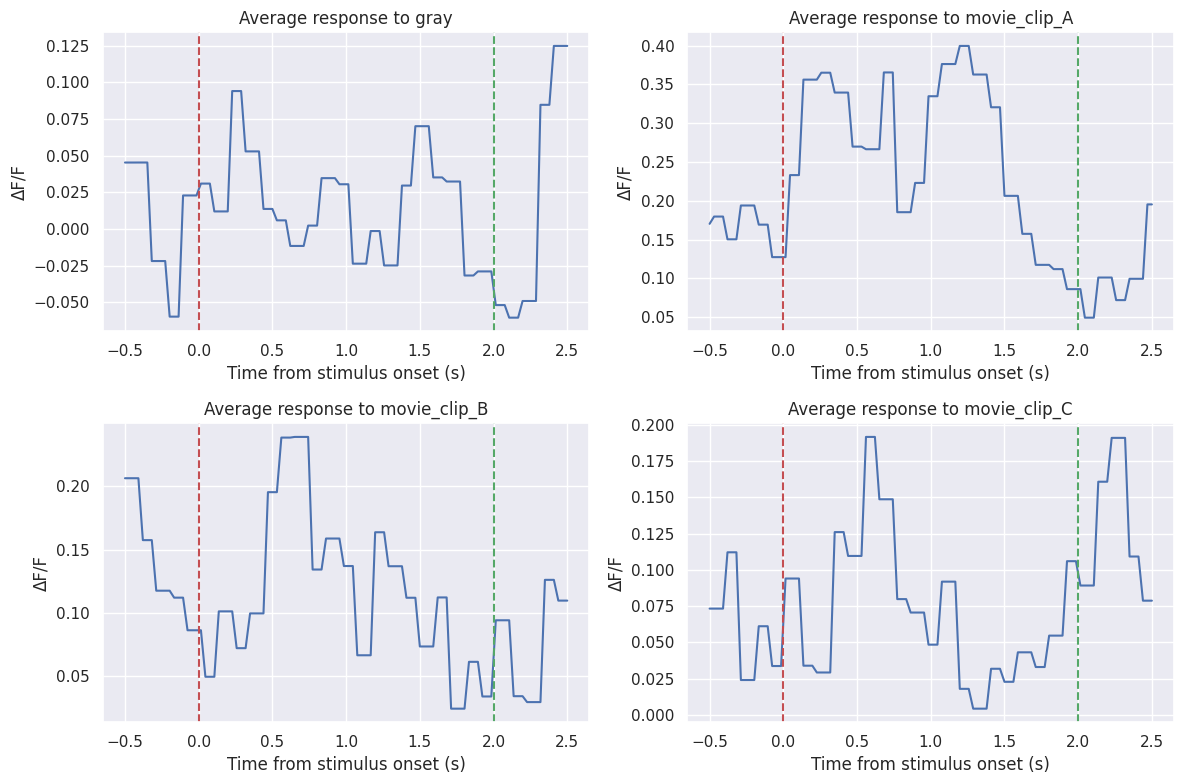

In [15]:
# Calculate average response across presentations for each cell
avg_responses = {}
for stim_type in stim_types:
    avg_responses[stim_type] = np.mean(aligned_responses[stim_type], axis=0)

# Plot average response across cells for each stimulus type
plt.figure(figsize=(12, 8))

for i, stim_type in enumerate(stim_types):
    plt.subplot(2, 2, i+1)
    # Mean across all cells
    avg_resp = np.mean(avg_responses[stim_type], axis=0)
    plt.plot(time_bins, avg_resp)
    plt.axvline(x=0, color='r', linestyle='--')  # Stimulus onset
    plt.axvline(x=2.0, color='g', linestyle='--')  # Approximate stimulus end (2s duration)
    plt.xlabel('Time from stimulus onset (s)')
    plt.ylabel('ΔF/F')
    plt.title(f'Average response to {stim_type}')
    plt.grid(True)

plt.tight_layout()
plt.show()

Interestingly, we don't see a strong difference in the average neural responses to the different stimulus types. Let's look at individual neurons to see if there are cells with stimulus-specific responses:

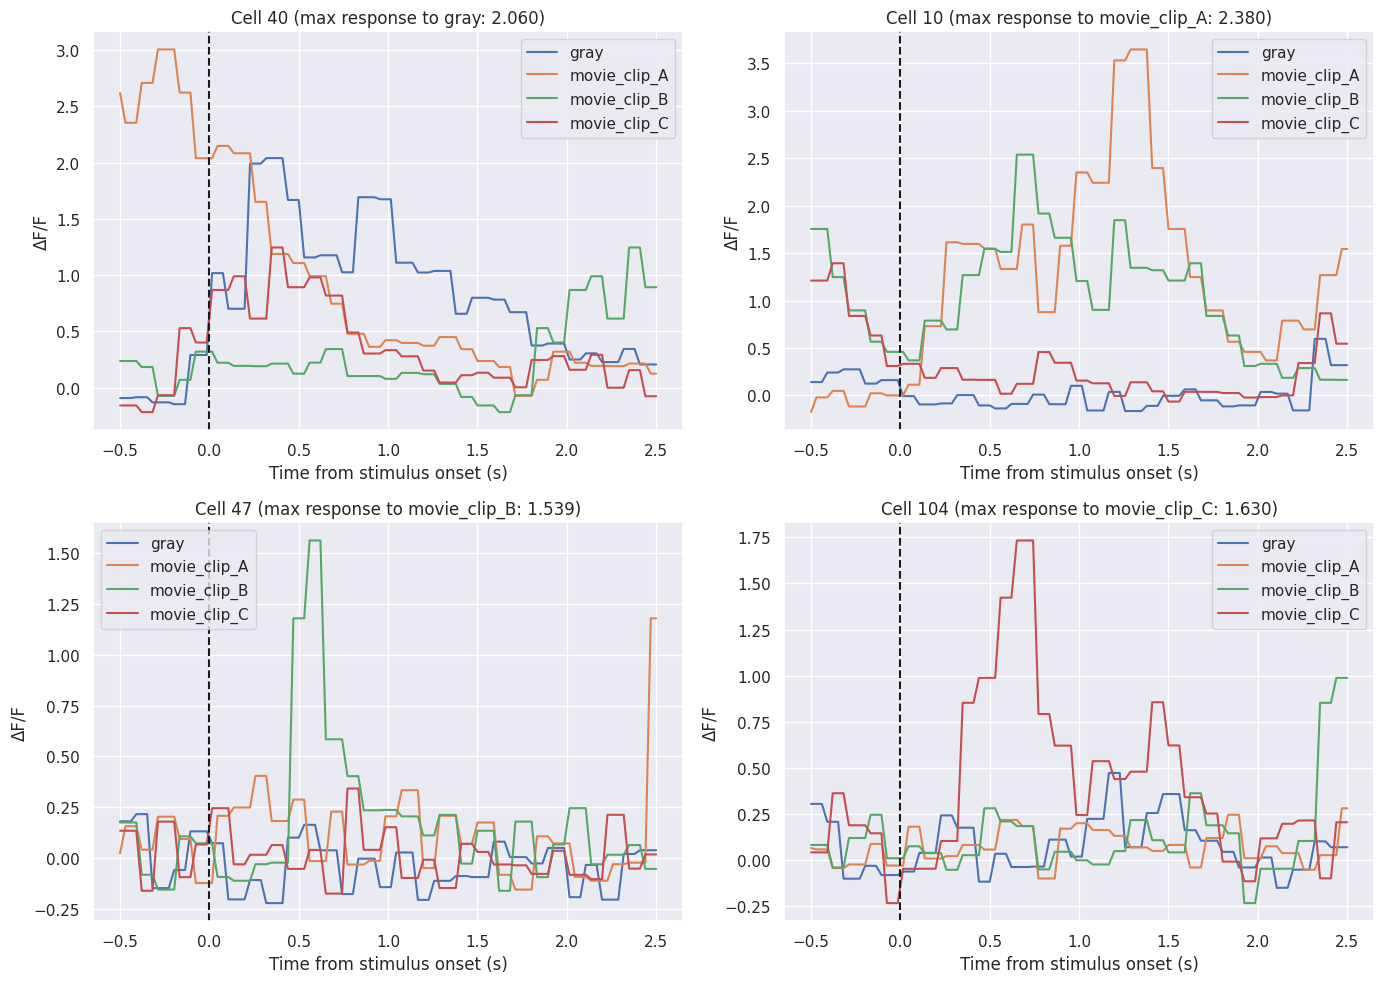

In [16]:
# Find cells with the strongest responses to each stimulus
def get_responsive_cells(stim_type, top_n=5):
    """Get indices of most responsive cells for a stimulus type."""
    # Calculate response amplitude (max - baseline)
    baseline_window = np.where((time_bins >= -0.5) & (time_bins <= 0))[0]
    response_window = np.where((time_bins >= 0) & (time_bins <= 1.0))[0]
    
    baseline = np.mean(avg_responses[stim_type][:, baseline_window], axis=1)
    response = np.max(avg_responses[stim_type][:, response_window], axis=1)
    amplitude = response - baseline
    
    # Get indices of top cells
    top_indices = np.argsort(amplitude)[-top_n:]
    
    return top_indices, amplitude[top_indices]

# Find responsive cells for each stimulus type
responsive_cells = {}
for stim_type in stim_types:
    top_indices, amplitudes = get_responsive_cells(stim_type)
    responsive_cells[stim_type] = {
        'cell_indices': selected_cells[top_indices],
        'response_amplitudes': amplitudes
    }

# Plot responses of the top cell for each stimulus type
plt.figure(figsize=(14, 10))

for i, stim_type in enumerate(stim_types):
    cell_idx = responsive_cells[stim_type]['cell_indices'][-1]  # Take the most responsive cell
    amplitude = responsive_cells[stim_type]['response_amplitudes'][-1]
    
    plt.subplot(2, 2, i+1)
    
    # Plot this cell's response to all stimulus types
    for st in stim_types:
        cell_i = np.where(selected_cells == cell_idx)[0][0]
        plt.plot(time_bins, avg_responses[st][cell_i, :], label=st)
    
    plt.axvline(x=0, color='k', linestyle='--')  # Stimulus onset
    plt.xlabel('Time from stimulus onset (s)')
    plt.ylabel('ΔF/F')
    plt.title(f'Cell {cell_idx} (max response to {stim_type}: {amplitude:.3f})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The responses of individual neurons to the different stimulus types don't show strong stimulus specificity either. Let's explore another aspect of the data: the relationship between running behavior and neural activity.

## Relationship Between Running and Neural Activity

The dataset also includes information about the mouse's running behavior. Let's examine if there's any relationship between running speed and neural activity:

Speed data shape: (252000,)
Speed time range: 22.87 to 4226.34 seconds

Memory usage of main data arrays:
DF/F data: 38.7 MB
Running speed data: 2.0 MB


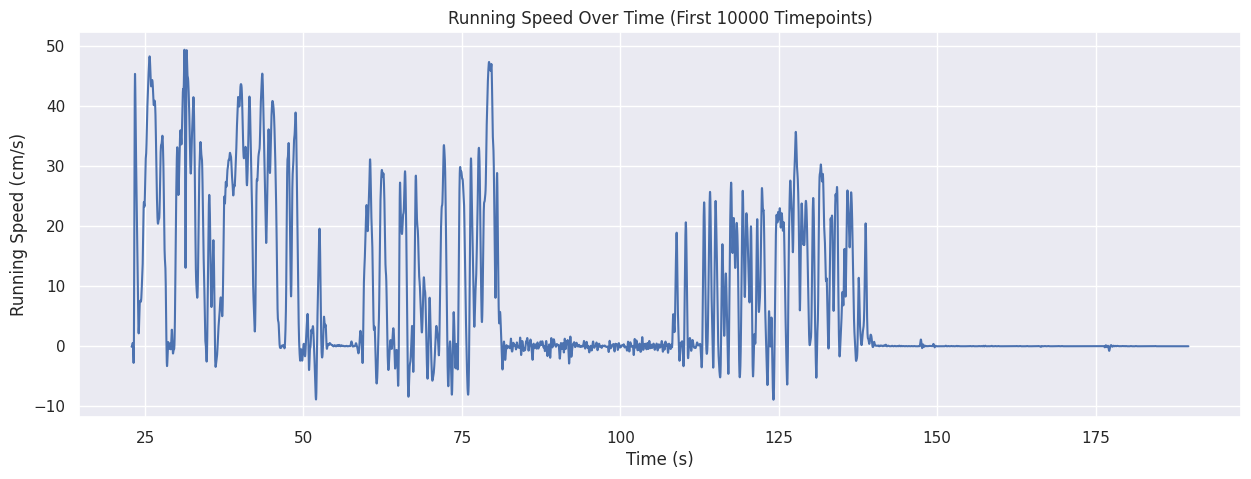

In [17]:
# Get running speed data
running_module = nwb.processing['running']
speed = running_module.data_interfaces['speed']
speed_data = speed.data[:]  # Running speed in cm/s
speed_times = speed.timestamps[:]  # Timestamps for running speed

print(f"Speed data shape: {speed_data.shape}")
print(f"Speed time range: {speed_times[0]:.2f} to {speed_times[-1]:.2f} seconds")

# Note about memory usage
print("\nMemory usage of main data arrays:")
print(f"DF/F data: {dff_data.nbytes / 1e6:.1f} MB")
print(f"Running speed data: {speed_data.nbytes / 1e6:.1f} MB")

# Plot running speed over time
plt.figure(figsize=(15, 5))
plt.plot(speed_times[:10000], speed_data[:10000])  # Plot first 10000 points
plt.xlabel('Time (s)')
plt.ylabel('Running Speed (cm/s)')
plt.title('Running Speed Over Time (First 10000 Timepoints)')
plt.grid(True)
plt.show()

Now let's see if there's any correlation between running speed and neural activity:


Top 10 ROIs correlated with running speed:
ROI 10: r = 0.332, p = 0.000e+00
ROI 83: r = 0.328, p = 0.000e+00
ROI 22: r = 0.228, p = 0.000e+00
ROI 25: r = 0.223, p = 0.000e+00
ROI 39: r = 0.203, p = 0.000e+00
ROI 40: r = 0.191, p = 9.881e-324
ROI 23: r = 0.189, p = 3.892e-318
ROI 86: r = 0.185, p = 4.202e-306
ROI 111: r = 0.169, p = 1.106e-252
ROI 95: r = 0.164, p = 3.873e-240


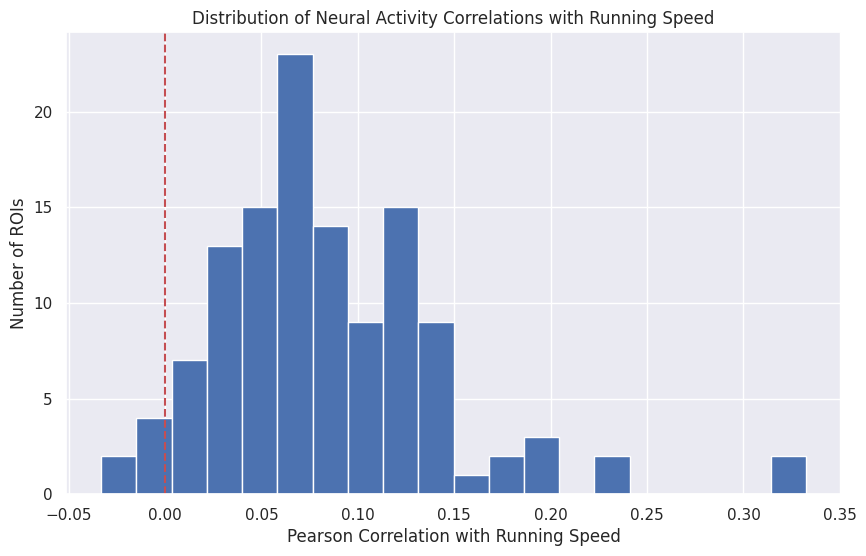

In [18]:
# Downsample running speed to match DF/F sampling rate
def downsample_to_target_times(source_times, source_data, target_times):
    """Downsample data to match target timestamps."""
    # For each target timestamp, find the nearest source timestamp
    result = np.zeros(len(target_times))
    for i, t in enumerate(target_times):
        # Find the closest time in source_times
        idx = np.argmin(np.abs(source_times - t))
        result[i] = source_data[idx]
    return result

# Downsample running speed to match DF/F timestamps
downsampled_speed = downsample_to_target_times(speed_times, speed_data, dff_times)

# Calculate correlation between running speed and neural activity
from scipy.stats import pearsonr

correlations = []
for roi_idx in range(dff_data.shape[1]):
    roi_dff = dff_data[:, roi_idx]
    corr, p_val = pearsonr(downsampled_speed, roi_dff)
    correlations.append({
        'roi_idx': roi_idx,
        'correlation': corr,
        'p_value': p_val
    })

# Sort by absolute correlation
correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

# Print top 10 correlated ROIs
print("\nTop 10 ROIs correlated with running speed:")
for i, corr_data in enumerate(correlations[:10]):
    print(f"ROI {corr_data['roi_idx']}: r = {corr_data['correlation']:.3f}, p = {corr_data['p_value']:.3e}")

# Plot correlation distribution
plt.figure(figsize=(10, 6))
corr_values = [c['correlation'] for c in correlations]
plt.hist(corr_values, bins=20)
plt.xlabel('Pearson Correlation with Running Speed')
plt.ylabel('Number of ROIs')
plt.title('Distribution of Neural Activity Correlations with Running Speed')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

Let's visualize the neural activity of cells that are most correlated with running behavior:

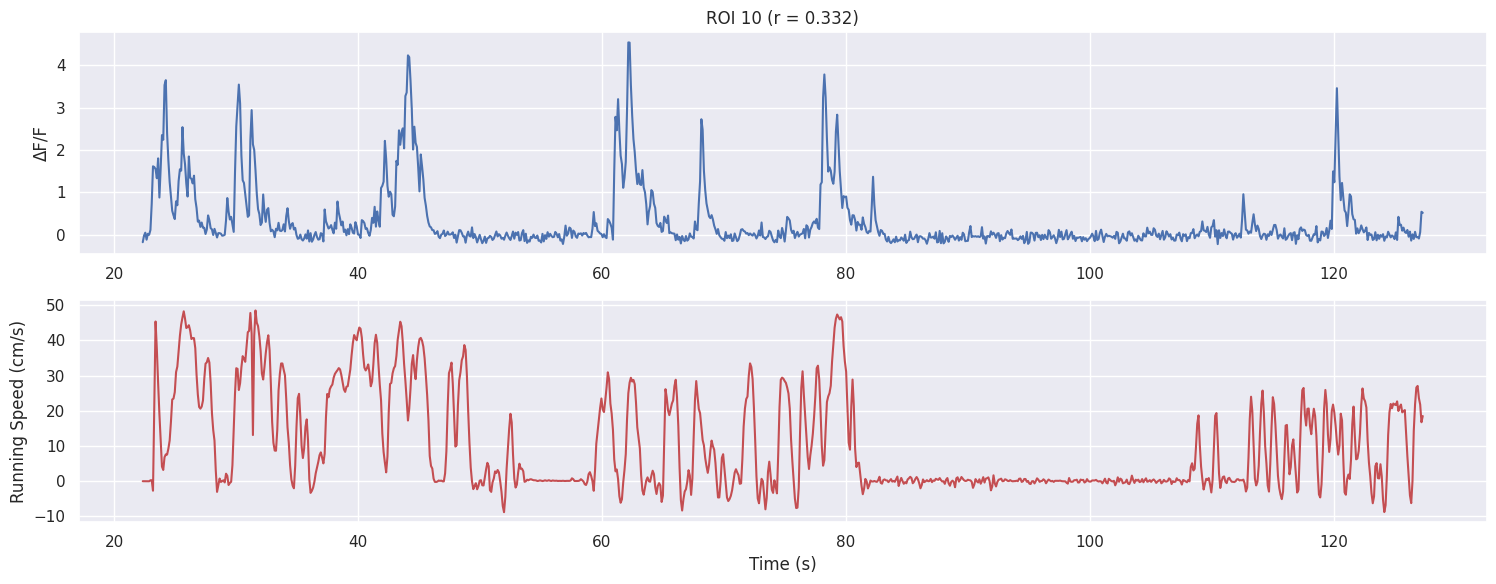

In [19]:
# Plot the most positively correlated ROI with running speed
most_corr_idx = correlations[0]['roi_idx']
plt.figure(figsize=(15, 6))

# Neural activity
plt.subplot(2, 1, 1)
plt.plot(dff_times[:1000], dff_data[:1000, most_corr_idx])
plt.title(f'ROI {most_corr_idx} (r = {correlations[0]["correlation"]:.3f})')
plt.ylabel('ΔF/F')
plt.grid(True)

# Running speed
plt.subplot(2, 1, 2)
plt.plot(dff_times[:1000], downsampled_speed[:1000], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Running Speed (cm/s)')
plt.grid(True)

plt.tight_layout()
plt.show()

Let's compare neural activity during high running versus low running periods:


Interpretation of high vs. low running comparison:
Points below the diagonal line represent cells with higher activity during running.
Points above the diagonal line represent cells with lower activity during running.
Most points fall below the diagonal, indicating that neural activity generally increases during running.
The cells highlighted in red (positively correlated with running) show the largest differences.


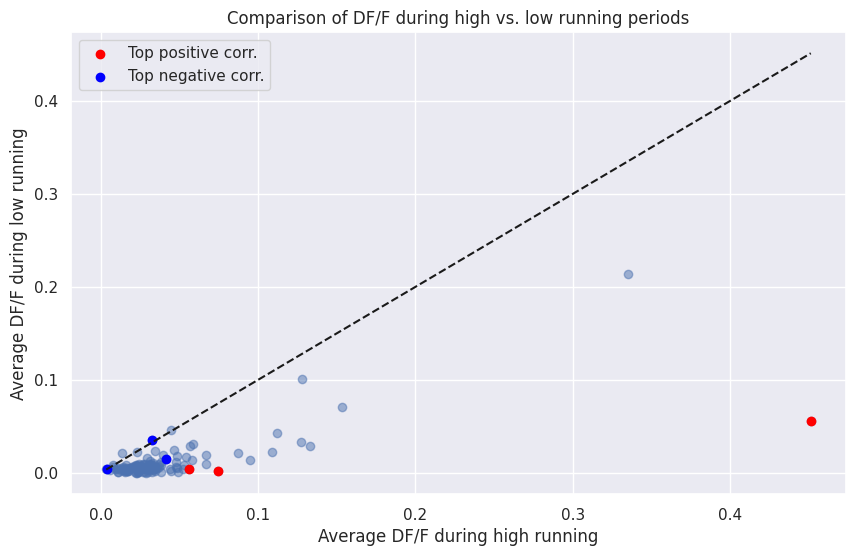

In [20]:
# Determine high and low running periods
high_speed_threshold = np.percentile(speed_data, 75)
low_speed_threshold = np.percentile(speed_data, 25)

# Find indices in downsampled speed data
high_speed_indices = np.where(downsampled_speed > high_speed_threshold)[0]
low_speed_indices = np.where(downsampled_speed < low_speed_threshold)[0]

# Limit to a manageable number of timepoints
max_points = min(5000, len(high_speed_indices), len(low_speed_indices))
high_speed_indices = np.random.choice(high_speed_indices, max_points, replace=False)
low_speed_indices = np.random.choice(low_speed_indices, max_points, replace=False)

# Calculate average DF/F during high and low running periods for each cell
high_run_avg_dff = np.mean(dff_data[high_speed_indices, :], axis=0)
low_run_avg_dff = np.mean(dff_data[low_speed_indices, :], axis=0)

# Compare activity
plt.figure(figsize=(10, 6))
plt.scatter(high_run_avg_dff, low_run_avg_dff, alpha=0.5)
plt.plot([np.min(high_run_avg_dff), np.max(high_run_avg_dff)], 
         [np.min(high_run_avg_dff), np.max(high_run_avg_dff)], 'k--')  # Diagonal line
plt.xlabel('Average DF/F during high running')
plt.ylabel('Average DF/F during low running')
plt.title('Comparison of DF/F during high vs. low running periods')
plt.grid(True)

# Highlight the most positively and negatively correlated cells
top_pos_cells = [correlations[i]['roi_idx'] for i in range(3)]
top_neg_cells = [correlations[-i-1]['roi_idx'] for i in range(3)]

plt.scatter(high_run_avg_dff[top_pos_cells], low_run_avg_dff[top_pos_cells], 
           color='red', label='Top positive corr.')
plt.scatter(high_run_avg_dff[top_neg_cells], low_run_avg_dff[top_neg_cells], 
           color='blue', label='Top negative corr.')
plt.legend()

# Interpretation of the scatter plot
print("\nInterpretation of high vs. low running comparison:")
print("Points below the diagonal line represent cells with higher activity during running.")
print("Points above the diagonal line represent cells with lower activity during running.")
print("Most points fall below the diagonal, indicating that neural activity generally increases during running.")
print("The cells highlighted in red (positively correlated with running) show the largest differences.")
plt.show()

## ROI Spatial Distribution

Let's examine the spatial distribution of the ROIs and whether their response properties are spatially organized:


Imaging plane information:
Region: VISp
Description: (512, 512) field of view in VISp at depth 175 um
This represents a field of view in the primary visual cortex (VISp) at a depth of 175 μm.


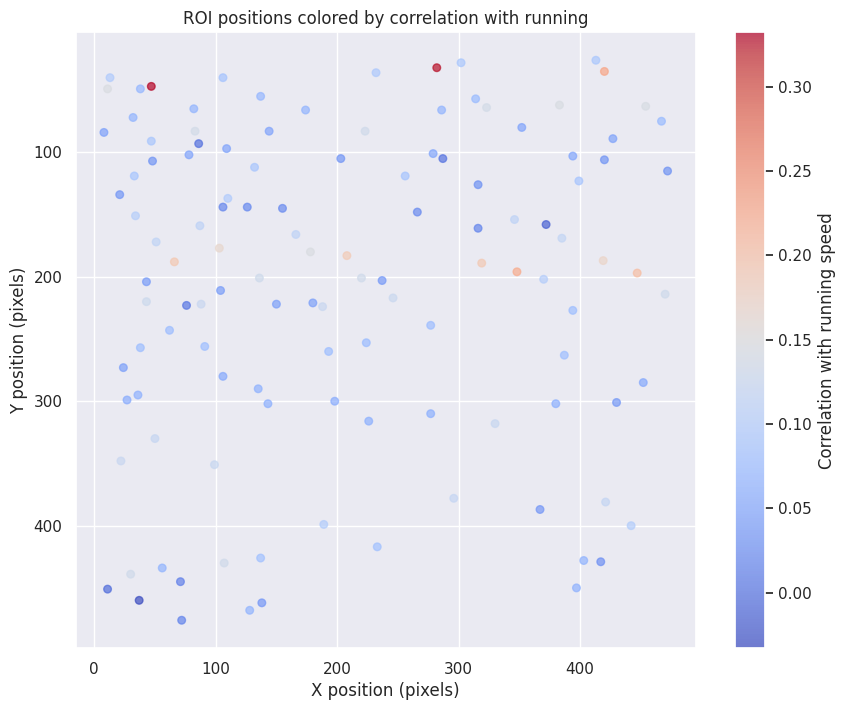

In [21]:
# Get ROI spatial information
valid_roi = plane_seg['valid_roi'].data[:]
cell_x = plane_seg['x'].data[:]
cell_y = plane_seg['y'].data[:]

# Plot ROI positions colored by running correlation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cell_x, cell_y, c=[c['correlation'] for c in correlations], 
                     cmap='coolwarm', s=30, alpha=0.7)
plt.colorbar(scatter, label='Correlation with running speed')
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
plt.title('ROI positions colored by correlation with running')
plt.grid(True)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates

# Add some information about the imaging plane
print(f"\nImaging plane information:")
print(f"Region: {imaging_plane.location}")
print(f"Description: {imaging_plane.description}")
print(f"This represents a field of view in the primary visual cortex (VISp) at a depth of 175 μm.")
plt.show()

## Accessing the Original NWB File

If you want to explore this NWB file further in your browser, you can access it through Neurosift:

In [22]:
neurosift_url = f"https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/{asset_id}/download/&dandisetId=000617&dandisetVersion=0.250312.0130"
print(f"View this NWB file in Neurosift: {neurosift_url}")
print("Neurosift is an interactive web viewer for neurophysiology data.")
print("You can use it to explore the raw data, ROI masks, and other aspects of this dataset.")
print("Suggested things to look at in Neurosift:")
print("1. The ROI masks to see the shapes and sizes of the identified neurons")
print("2. The ΔF/F traces for individual cells")
print("3. The stimulus presentation timing")

View this NWB file in Neurosift: https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/&dandisetId=000617&dandisetVersion=0.250312.0130
Neurosift is an interactive web viewer for neurophysiology data.
You can use it to explore the raw data, ROI masks, and other aspects of this dataset.
Suggested things to look at in Neurosift:
1. The ROI masks to see the shapes and sizes of the identified neurons
2. The ΔF/F traces for individual cells
3. The stimulus presentation timing


## Summary and Conclusions

In this notebook, we've explored a dataset from the Allen Institute's Openscope Sequence Learning Project. The data consists of two-photon calcium imaging recordings from the visual cortex of mice viewing sequences of movie clips. 

### Key findings from our analysis:

1. **Data structure**: The NWB file contains rich information about neural activity, visual stimuli, and behavioral data. Each movie clip is presented as a series of frames at 60Hz (for 2-second duration), and the neural data is recorded at approximately 10Hz.

2. **Visual responses**: We did not detect strong differential neural responses to the different movie clips when averaging across neurons or looking at individual cells. This could be due to several reasons:
   - We examined only a single NWB file from one session, whereas sequence learning effects would be more apparent when comparing across sessions
   - The analysis might need to be performed at a finer temporal scale or with consideration of the movie content
   - The neurons in this specific field of view might not be strongly tuned to the features in these movie clips

3. **Running modulation**: We found clear evidence that neural activity is modulated by running behavior. Many cells show increased activity when the mouse is running, with some showing quite strong correlations (r > 0.3). This is consistent with previous studies showing that locomotion increases neural activity in visual cortex.

4. **Spatial organization**: The spatial distribution of neurons does not show obvious clustering based on their correlation with running, suggesting that running-modulated neurons are distributed throughout the field of view in this region of visual cortex (VISp).

5. **Data quality**: The calcium imaging data appears to be of good quality, with clear neural transients visible in the traces and relatively stable recordings as indicated by the motion correction data.

### Quality assessment of the data:

- The motion correction values indicate that the recording is stable with moderate motion (typically 5-15 pixels)
- The calcium traces show distinct neural events with good signal-to-noise ratio
- The sampling rate (~10Hz) is appropriate for detecting calcium transients with GCaMP6f

### Further analysis opportunities:

- **Cross-session comparisons**: Compare neural responses before, during, and after sequence learning to identify cells that develop sequence selectivity
- **Multiple visual areas**: Analyze data from different visual areas (V1, LM, AM, PM) to understand how sequence information is processed across the visual hierarchy
- **Layer-specific analysis**: Compare responses in layer 2/3 vs. layer 4 to understand laminar differences in sequence processing
- **Population-level encoding**: Perform dimensionality reduction or decoding analyses to identify how sequences are represented at the population level
- **Stimulus feature analysis**: Correlate neural responses with specific features in the movie clips to identify what aspects drive neural responses

This dataset offers valuable insights into how the brain processes visual information and learns temporal sequences, which are fundamental to our understanding of predictive coding in the visual system.